# Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT
- SOURCE : https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
- https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/natural_language_processing/example_text_classification.ipynb

# Load librairies

In [ ]:
## for data
import json
import pandas as pd
import numpy as np
from random import seed, sample

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, plot_confusion_matrix,precision_recall_curve, auc

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

# Load the dataset
- https://www.kaggle.com/rmisra/news-category-dataset
- This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost.
- Each news headline has a corresponding category (politics, entertainement, science,...)

In [2]:
lst_dics = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
## print the first one
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [3]:
len(lst_dics)

200853

- Select a sample of categories from the 30 available

In [4]:
## create dtf
dtf = pd.DataFrame(lst_dics)
## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
## rename columns
dtf = dtf.rename(columns={"category":"y", "headline":"text"})
## print 5 random rows
dtf.sample(5)

,y,text
111142,ENTERTAINMENT,There Is No Mystery to The Mysteries of Laura
45784,POLITICS,"Yo, Undecided Voters! Are You Listening? Are Y..."
12809,POLITICS,Bump Stock Maker Resumes Sales One Month After...
2734,ENTERTAINMENT,"Indiana Jones Could Be Played By A Woman, Stev..."
1203,POLITICS,Ohio Democrats Fret Over Dennis Kucinich’s Fri...


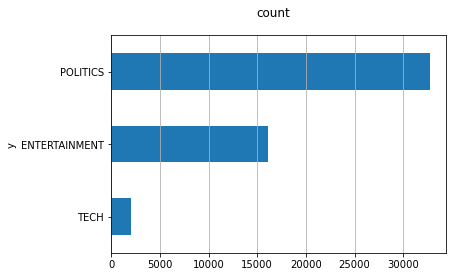

In [5]:
fig, ax = plt.subplots()
fig.suptitle("count", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

- We observe that the dataset is squewed with a significant under-representation of the 'TECH' class. This will negatively influence the learning phase undermining the classification performance of the under-represented class.
- This could be soften through improved sampling or by applying weights to the loss function. The project is not dealing with this issue and rather observes how each of the classification model performs with this issue.

# Preprocessing
- Tokenize into words, Remove punctuation, lower text, remove stopwords, lemmatize

In [6]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

- we obtain clean text from the source

In [8]:
# increase the display.width then you can see the whole data on one single row
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

dtf["text_clean"] = dtf["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
dtf.head()

,y,text,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,smith join diplo nicky jam 2018 world cup official song
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,jim carrey blast castrato adam schiff democrat new artwork
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,julianna margulies us donald trump poop bag pick dog
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harassment Claims Could Undermine Legacy,morgan freeman devastated sexual harassment claim could undermine legacy


# Prepare train and validation sets
- Validation set using 30% of the dataset

In [9]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

# Approach N°1 : BAG-OF-WORD (BOW)
- The Bag-of-Words model is simple: it builds a vocabulary from a corpus of documents and counts how many times the words appear in each document. To put it another way, each word in the vocabulary becomes a feature and a document is represented by a vector with the same length of the vocabulary (a “bag of words”).
- Terms frequency is not necessarily the best representation for text. In fact, you can find in the corpus common words with the highest frequency but little predictive power over the target variable. To address this problem there is an advanced variant of the Bag-of-Words that, instead of simple counting, uses the term frequency–inverse document frequency (or Tf–Idf). Basically, the value of a word increases proportionally to count, but it is inversely proportional to the frequency of the word in the corpus.

In [10]:
## Count (classic BoW) - will NOT be used
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

### Extract vocabulary and create the feature matrix from the train set

In [11]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

- we obtain sparse vectors for each news piece (only 10.000 most frequent words retained as vocabulary - bigrams are considered)

In [12]:
X_train.shape

(35615, 10000)

In [13]:
# word to index dictionary
dic_vocabulary

{'gop': 3690,
 'congressman': 1910,
 'urge': 9410,
 'health': 3979,
 'care': 1411,
 'obamacare': 6127,
 'repeal': 7215,
 'gop congressman': 3694,
 'health care': 3981,
 'obamacare repeal': 6130,
 'mitt': 5695,
 'romney': 7485,
 'huge': 4208,
 'new': 5927,
 'problem': 6825,
 'mitt romney': 5696,
 'peace': 6449,
 'spotify': 8275,
 'band': 786,
 'pull': 6910,
 'music': 5810,
 'streaming': 8439,
 'service': 7910,
 'streaming service': 8440,
 'authorization': 697,
 'use': 9415,
 'military': 5631,
 'force': 3374,
 'isi': 4468,
 'broad': 1231,
 'psa': 6894,
 'tell': 8699,
 'keep': 4783,
 'pant': 6353,
 'valentine': 9433,
 'day': 2252,
 'valentine day': 9434,
 'nyt': 6106,
 'bloomberg': 1090,
 'planning': 6593,
 'independent': 4341,
 'presidential': 6762,
 'run': 7542,
 'presidential run': 6771,
 'chris': 1613,
 'christie': 1628,
 'trash': 8962,
 'steve': 8372,
 'bannon': 794,
 'questioning': 6957,
 'loyalty': 5271,
 'trump': 9017,
 'chris christie': 1615,
 'steve bannon': 8373,
 'lucy': 5275,

Text(0.5, 1.0, 'Sparse Matrix Sample')

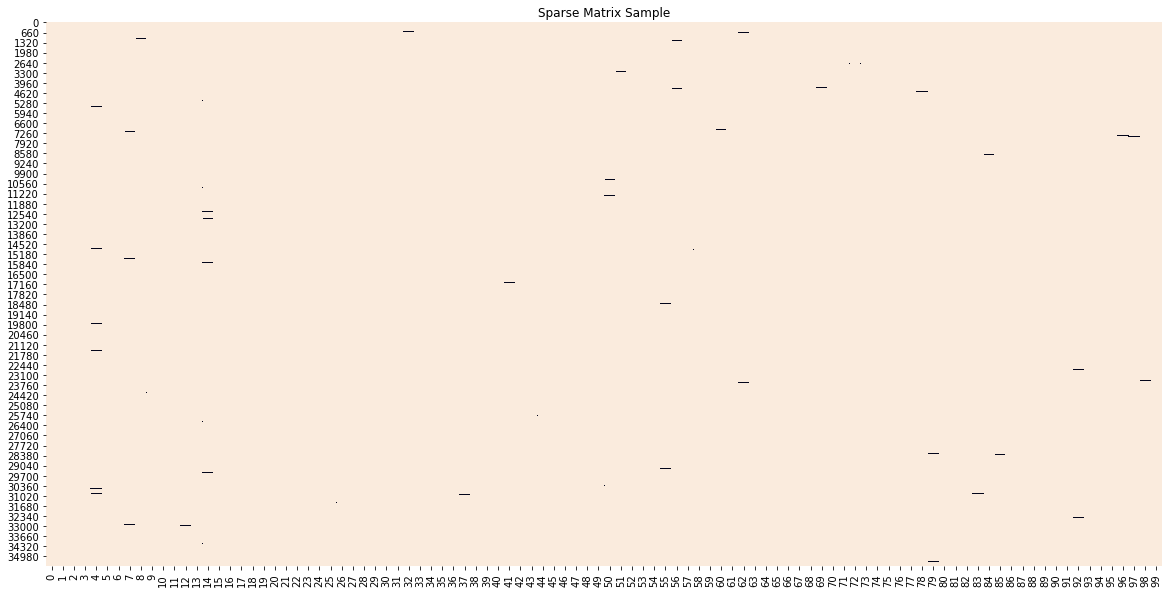

In [14]:
plt.figure(figsize=(20,10))
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [15]:
word = "new york"
dic_vocabulary[word]

5990

### Dimensionality reduction through feature selection
- In order to drop some columns and reduce the matrix dimensionality, perform Feature Selection, the process of selecting a subset of relevant variables.
    - treat each category as binary (for example, the “Tech” category is 1 for the Tech news and 0 for the others);
    - perform a Chi-Square test to determine whether a feature and the (binary) target are independent;
    - keep only the features with a certain p-value from the Chi-Square test.

In [16]:
'''
Perform feature selection using p-values (keep highly correlated features)
:parameter
    :param X: array - like sparse matrix or dtf.values
    :param y: array or dtf - like dtf["y"]
    :param X_names: list - like vetcorizer.get_feature_names()
    :param top: int - ex. 1000 takes the top 1000 features per classes of y. If None takes all those with p-value < 5%.'''

y = dtf_train["y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [17]:
dtf_features

,feature,score,y
223,actor,1.000000,ENTERTAINMENT
345,album,1.000000,ENTERTAINMENT
714,award,1.000000,ENTERTAINMENT
1161,box,1.000000,ENTERTAINMENT
1162,box office,1.000000,ENTERTAINMENT
...,...,...,...
409,america,0.953324,TECH
0,10,0.951498,TECH
6127,obamacare,0.950943,TECH
8280,spree,0.950766,TECH


In [18]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")

# ENTERTAINMENT:
  . selected features: 3087
  . top features: actor,album,award,box,box office,celebrity,clinton,dead,democrat,donald
 
# POLITICS:
  . selected features: 3063
  . top features: album,apple,award,box,box office,clinton,democrat,donald,donald trump,fan
 
# TECH:
  . selected features: 462
  . top features: amazon,android,app,apple,apple rumor,apps,bug,car,computer,cyber
 


- Re-vectorize the corpus using this focused vocabulary set

In [19]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

- number of features reduced from 10,000 to 3,672 by keeping the most statistically relevant words.

In [20]:
X_train.shape

(35615, 3675)

In [21]:
dic_vocabulary

{'actor': 0,
 'album': 1,
 'award': 2,
 'box': 3,
 'box office': 4,
 'celebrity': 5,
 'clinton': 6,
 'dead': 7,
 'democrat': 8,
 'donald': 9,
 'donald trump': 10,
 'fan': 11,
 'festival': 12,
 'film': 13,
 'game': 14,
 'game throne': 15,
 'gop': 16,
 'hillary': 17,
 'hollywood': 18,
 'jenner': 19,
 'jennifer': 20,
 'justin': 21,
 'kanye': 22,
 'kardashian': 23,
 'kim kardashian': 24,
 'movie': 25,
 'music': 26,
 'netflix': 27,
 'obama': 28,
 'oscar': 29,
 'republican': 30,
 'season': 31,
 'snl': 32,
 'song': 33,
 'star': 34,
 'star war': 35,
 'swift': 36,
 'taylor': 37,
 'taylor swift': 38,
 'throne': 39,
 'trailer': 40,
 'trump': 41,
 'girl': 42,
 'kim': 43,
 'hillary clinton': 44,
 'amy': 45,
 'sander': 46,
 'performance': 47,
 'singer': 48,
 'baby': 49,
 'state': 50,
 'rock': 51,
 'kylie': 52,
 'kanye west': 53,
 'senate': 54,
 'court': 55,
 'beyoncé': 56,
 'premiere': 57,
 'show': 58,
 'bernie': 59,
 'walking dead': 60,
 'kylie jenner': 61,
 'bernie sander': 62,
 'cyrus': 63,
 'mil

In [22]:
len(dic_vocabulary)

3675

Text(0.5, 1.0, 'Sparse Matrix Sample')

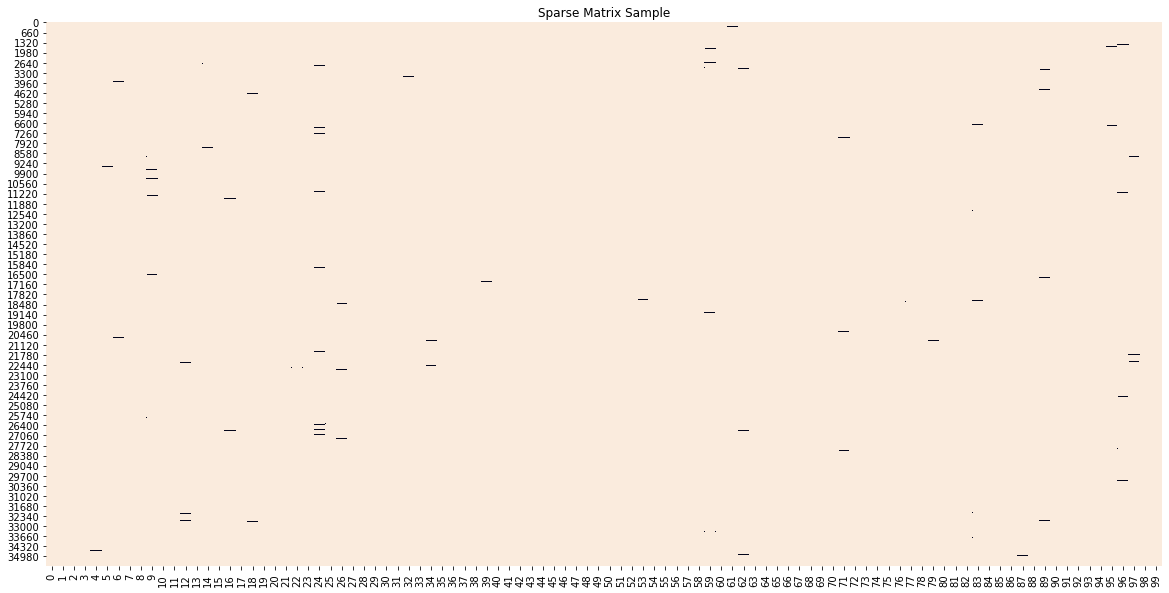

In [23]:
plt.figure(figsize=(20,10))
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

# Train a naive-bayes model on this BOW representation of the news

In [24]:
classifier = naive_bayes.MultinomialNB()

In [25]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

# Evaluate performance
- Poor performance on the under-represented class

Accuracy: 0.91
Auc: 0.97
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.87      0.89      4843
     POLITICS       0.91      0.97      0.94      9770
         TECH       0.92      0.34      0.49       651

     accuracy                           0.91     15264
    macro avg       0.91      0.72      0.77     15264
 weighted avg       0.91      0.91      0.90     15264



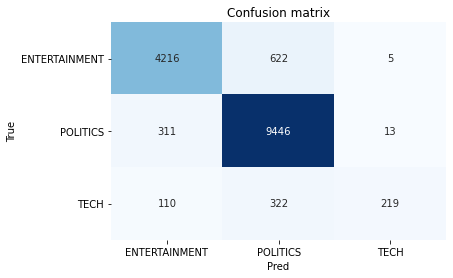

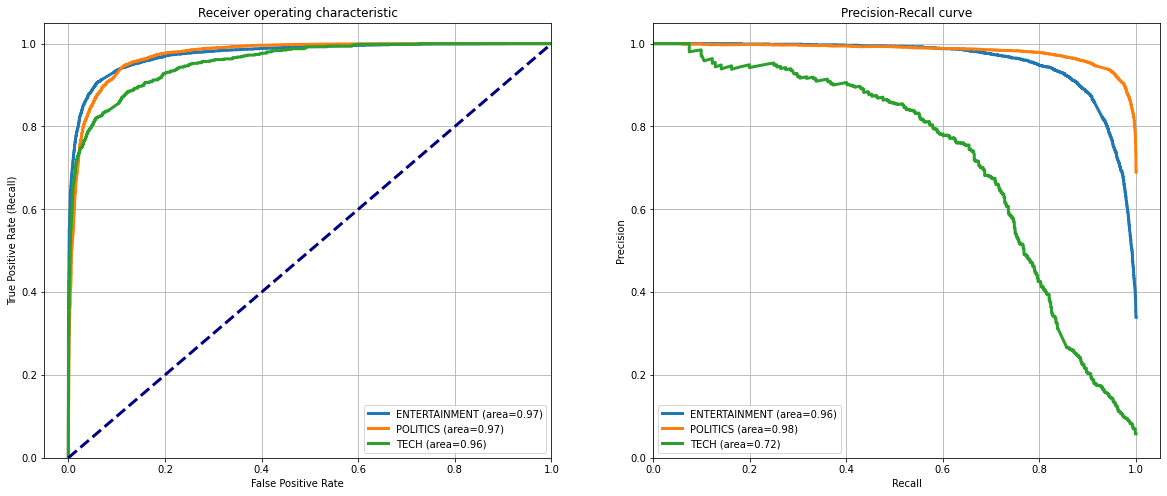

In [26]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, predicted)
auc_ = roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc_,2))
print("Detail:")
print(classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3,  label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(recall, precision)))
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Explainability of model predictions using lime

In [27]:
## select observation
i = 0
txt_instance = dtf_test["text"].iloc[i]
print('Sample to explain prediction outcome:', txt_instance)
print()
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names= np.unique(y_train))
explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)


Sample to explain prediction outcome: No, The GOP Health Care Bill Does Not Protect Those With Pre-Existing Conditions

True: POLITICS --> Pred: POLITICS | Prob: 1.0


# Approach N°2 : WORD EMBEDDING
- Word Embedding is the collective name for feature learning techniques where words from the vocabulary are mapped to vectors of real numbers.
- These vectors are calculated from the probability distribution for each word appearing before or after another. To put it another way, words of the same context usually appear together in the corpus, so they will be close in the vector space as well.
- use the first model of this family: Google’s Word2Vec (2013). Other popular Word Embedding models are Stanford’s GloVe (2014) and Facebook’s FastText (2016)
- Word2Vec produces a vector space, typically of several hundred dimensions, with each unique word in the corpus such that words that share common contexts in the corpus are located close to one another in the space.
- That can be done using 2 different approaches: starting from a single word to predict its context (Skip-gram) or starting from the context to predict a word (Continuous Bag-of-Words).

### load a pre-trained Word Embedding model from gensim-data

In [28]:
#nlp = gensim_api.load("word2vec-google-news-300")

### Fit own word embedding

In [29]:
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [36]:
len(corpus)

35615

- Determine a word embedding of dimension 300 looking at the 8 closest words for context

In [30]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300, window=8, min_count=1, sg=1, iter=30)

In [31]:
word = "data"
try:
    nlp[word].shape
except:
    print("word <data> not found")

C:\Users\lveys\anaconda3\envs\tensorflow_py37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
dir(nlp)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_check_input_data_sanity',
 '_check_training_sanity',
 '_clear_post_train',
 '_do_train_epoch',
 '_do_train_job',
 '_get_job_params',
 '_get_thread_working_mem',
 '_job_producer',
 '_load_specials',
 '_log_epoch_end',
 '_log_epoch_progress',
 '_log_progress',
 '_log_train_end',
 '_minimize_model',
 '_raw_word_count',
 '_save_specials',
 '_set_train_params',
 '_smart_save',
 '_train_epoch',
 '_train_epoch_corpusfile',
 '_update_job_params',
 '_worker_loop',
 '_worker_loop_corpusfile',
 'accuracy',
 'alpha',
 'batch_words',
 'build_vocab',
 'build_vocab_from_freq',
 'ca

- Each word is not reprsented by a vector of size 300

In [33]:
nlp.vector_size

300

## Visualize word embeddings in 3D using t-SNE

In [34]:
'''
Plot words in vector space (2d or 3d).
:parameter
    :param lst_words: list - ["donald trump","china", ...]. If None, it plots the whole vocabulary
    :param nlp: gensim model
    :param plot_type: string - "2d" or "3d"
    :param top: num - plot top most similar words (only if lst_words is given)
    :param annotate: bool - include word text
'''
def plot_w2v(lst_words=None, nlp=None, plot_type="2d", top=20, annotate=True, figsize=(10,5)):
    nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
    fig = plt.figure(figsize=figsize)
    if lst_words is not None:
        fig.suptitle("Word: "+lst_words[0], fontsize=12) if len(lst_words) == 1 else fig.suptitle("Words: "+str(lst_words[:5]), fontsize=12)
    else:
        fig.suptitle("Vocabulary")
    try:
        ## word embedding
        tot_words = lst_words + [tupla[0] for tupla in nlp.most_similar(lst_words, topn=top)] if lst_words is not None else list(nlp.vocab.keys())
        X = nlp[tot_words]
        
        ## pca
        pca = manifold.TSNE(perplexity=40, n_components=int(plot_type[0]), init='pca')
        X = pca.fit_transform(X)

        ## create dtf
        columns = ["x","y"] if plot_type == "2d" else ["x","y","z"]
        dtf = pd.DataFrame(X, index=tot_words, columns=columns)
        dtf["input"] = 0
        if lst_words is not None:
            dtf["input"].iloc[0:len(lst_words)] = 1  #<--this makes the difference between vocabulary and input words
        
        ## plot 2d
        if plot_type == "2d": 
            ax = fig.add_subplot()
            sns.scatterplot(data=dtf, x="x", y="y", hue="input", legend=False, ax=ax, palette={0:'black',1:'red'})
            ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
            if annotate is True:
                for i in range(len(dtf)):
                    ax.annotate(dtf.index[i], xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
                                xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
        
        ## plot 3d
        elif plot_type == "3d":
            from mpl_toolkits.mplot3d import Axes3D
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(dtf[dtf["input"]==0]['x'], dtf[dtf["input"]==0]['y'], dtf[dtf["input"]==0]['z'], c="black")
            ax.scatter(dtf[dtf["input"]==1]['x'], dtf[dtf["input"]==1]['y'], dtf[dtf["input"]==1]['z'], c="red")
            ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
            if annotate is True:
                for label, row in dtf[["x","y","z"]].iterrows():
                    x, y, z = row
                    ax.text(x, y, z, s=label)
            
        plt.show()
        
    except Exception as e:
        print("--- got error ---")
        print(e)
        word = str(e).split("'")[1]
        print("maybe you are looking for ... ")
        print([k for k in list(nlp.vocab.keys()) if 1-nltk.jaccard_distance(set(word),set(k)) > 0.7])

<IPython.core.display.Javascript object>


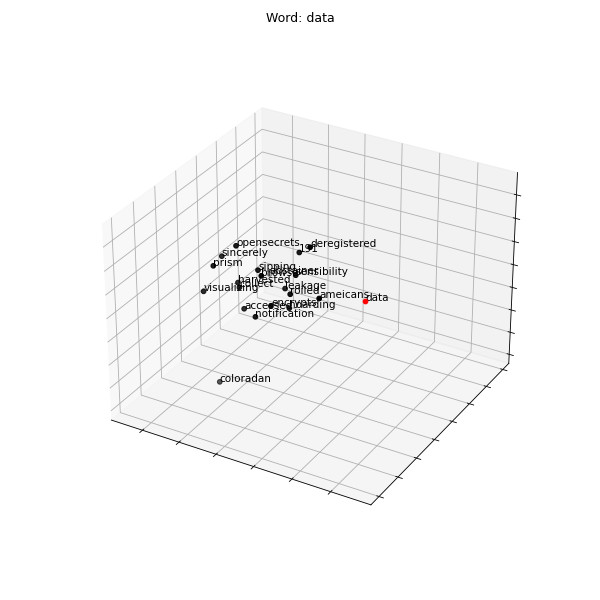

C:\Users\lveys\anaconda3\envs\tensorflow_py37\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
C:\Users\lveys\anaconda3\envs\tensorflow_py37\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\lveys\anaconda3\envs\tensorflow_py37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [35]:
%matplotlib notebook
plot_w2v(lst_words=[word], nlp=nlp, plot_type="3d", top=20, figsize=(8,8))

- right click mouse to zoom

# Use word embeddings to predict categories
- how can the word embedding be useful to predict the news category? Well, the word vectors can be used in a neural network as weights. This is how:
    - First, transform the corpus into padded sequences of word ids to get a feature matrix.
    - Then, create an embedding matrix so that the vector of the word with id N is located at the Nth row.
    - Finally, build a neural network with an embedding layer that weighs every word in the sequences with the corresponding vector.
    
    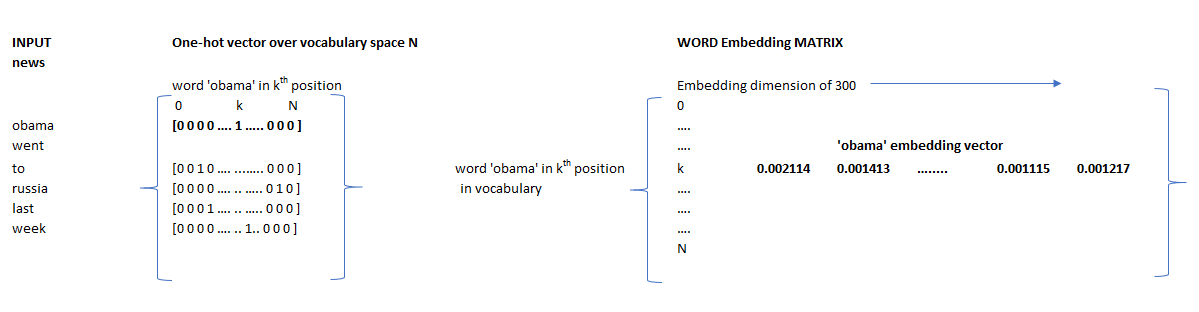

### Step 1: Feature Engineering: transforming the same preprocessed corpus (list of lists of n-grams) given to the Word2Vec into a list of sequences using tensorflow/keras
- pad news to length of 15 tokens

In [37]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="UNK", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

In [38]:
dic_vocabulary

{'UNK': 1,
 'trump': 2,
 'donald': 3,
 'new': 4,
 'say': 5,
 'clinton': 6,
 'gop': 7,
 'u': 8,
 'obama': 9,
 'republican': 10,
 'hillary': 11,
 'house': 12,
 'get': 13,
 'american': 14,
 'white': 15,
 'bill': 16,
 'democrat': 17,
 'court': 18,
 'first': 19,
 'want': 20,
 'show': 21,
 'state': 22,
 'year': 23,
 'make': 24,
 'sander': 25,
 'woman': 26,
 'president': 27,
 'senate': 28,
 'call': 29,
 'day': 30,
 'one': 31,
 'campaign': 32,
 'people': 33,
 'time': 34,
 'star': 35,
 'bernie': 36,
 'election': 37,
 'could': 38,
 'war': 39,
 'back': 40,
 'know': 41,
 'john': 42,
 'email': 43,
 'right': 44,
 'here': 45,
 'need': 46,
 'america': 47,
 'health': 48,
 'video': 49,
 'like': 50,
 'supreme': 51,
 'gun': 52,
 'voter': 53,
 'take': 54,
 'watch': 55,
 'plan': 56,
 'care': 57,
 'big': 58,
 'movie': 59,
 'vote': 60,
 'may': 61,
 'would': 62,
 'dont': 63,
 'report': 64,
 'win': 65,
 'paul': 66,
 'law': 67,
 'congress': 68,
 'still': 69,
 'tax': 70,
 'go': 71,
 'debate': 72,
 'wont': 73,
 't

In [39]:
len(dic_vocabulary)

22479

In [40]:
lst_text2seq

[[7, 207, 544, 12580, 48, 57, 87, 287],
 [751, 666, 615, 4, 7680, 226],
 [12581, 1284, 3560, 1014, 1213, 159, 3361, 460],
 [3362, 429, 414, 404, 378, 3363],
 [4715, 128, 210, 3364, 1975, 30],
 [2845, 4040, 2140, 1711, 135, 193],
 [134, 422, 2508, 309, 946, 2720, 5195, 2],
 [5816, 12582, 461, 79, 6613, 752, 947],
 [82, 242, 1065, 574, 1457, 489, 39, 1239, 6614],
 [70, 1001, 591, 863],
 [26, 3561, 78, 3011, 50, 148, 1015],
 [185, 418, 12, 892, 4716, 282, 356, 575, 1976],
 [4717, 10, 1868, 1571, 602, 1764, 430, 3011],
 [775, 2509, 187, 40, 1977, 9432, 819],
 [2, 592, 151, 12583],
 [19, 105, 2045, 4718, 2413, 3793, 12584, 12585],
 [3794, 21, 4719, 2414, 238, 1765, 2611, 14],
 [504, 9433, 361, 538, 21, 6615],
 [10, 243, 5, 83],
 [545, 5817, 398, 7681, 3012, 1047, 22, 3795],
 [138, 72, 323, 677],
 [567, 392],
 [75, 452, 68, 926, 91, 9, 3562, 1031, 39],
 [1129, 7682, 188, 3563, 12586, 199, 21, 204],
 [518, 11, 6, 1420, 157, 264],
 [288, 689, 1240, 3365, 399, 4720],
 [3, 2, 92, 1313],
 [698, 2

In [41]:
len(lst_text2seq)

35615

In [42]:
X_train

array([[    7,   207,   544, ...,     0,     0,     0],
       [  751,   666,   615, ...,     0,     0,     0],
       [12581,  1284,  3560, ...,     0,     0,     0],
       ...,
       [ 3933,  4499,    21, ...,     0,     0,     0],
       [ 9069,   322,  2178, ...,     0,     0,     0],
       [  250,   306,   337, ...,     0,     0,     0]])

In [43]:
X_train.shape

(35615, 15)

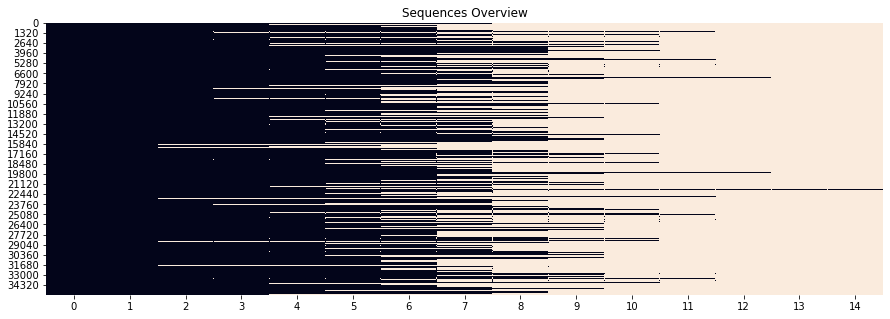

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sequences Overview')
plt.show()

In [45]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  gop congressman urge selfrationing health care obamacare repeal | len: 8
to:  [    7   207   544 12580    48    57    87   287     0     0     0     0
     0     0     0] | len: 15
check:  gop  -- idx in vocabulary --> 7
vocabulary:  {'UNK': 1, 'trump': 2, 'donald': 3, 'new': 4, 'say': 5} ... (padding element, 0)


### feature engineering on test set

In [46]:
corpus = dtf_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,padding="post", truncating="post")

### step 2: Create matrix of embeddings
- will be used as a weight matrix in the neural network classifier

In [47]:
## start the matrix (length of vocabulary x vector size) with all 0s
## add one for UNK token
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

C:\Users\lveys\anaconda3\envs\tensorflow_py37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [48]:
word = "data"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 509 |idx
embeddings[idx]: (300,) |vector


### Step 3 : deep leaning model
- use the embedding matrix in the first Embedding layer of the neural network and train to classify the news.
- Each id in the input sequence will be used as the index to access the embedding matrix.
- The output of this Embedding layer will be a 2D matrix with a word vector for each word id in the input sequence (Sequence length x Vector size).
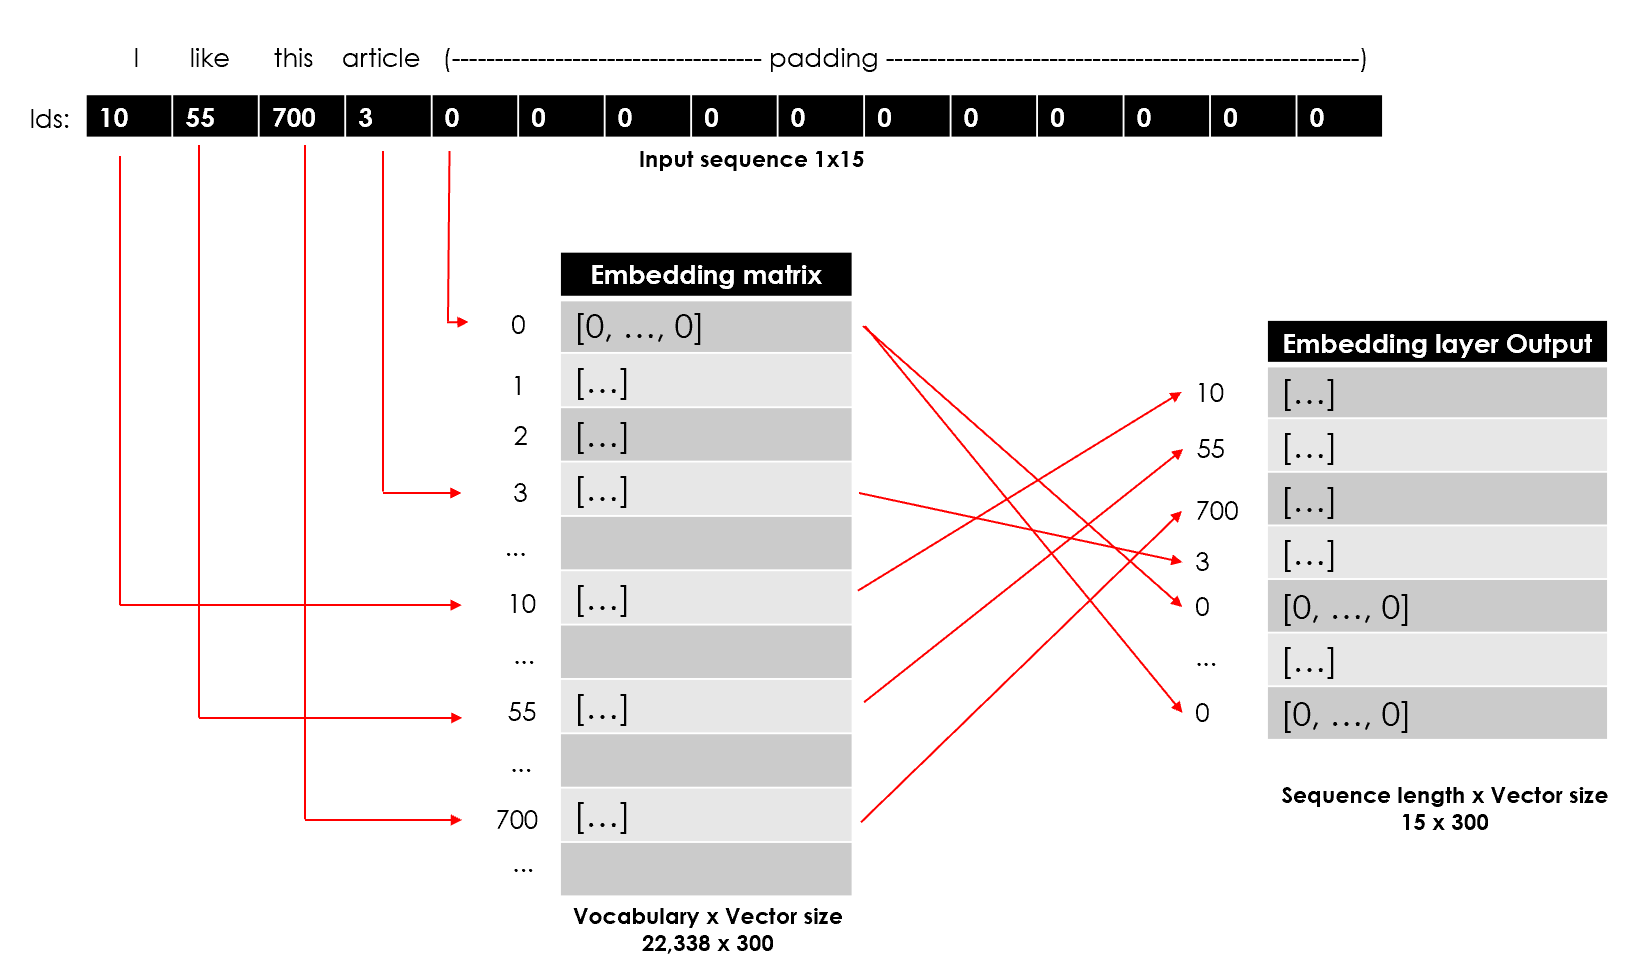

The neural network shall be structured as follows:
- an Embedding layer that takes the sequences as input and the word vectors as weights, just as described before.
- A simple Attention layer that won’t affect the predictions but it’s going to capture the weights of each instance and allow us to build a nice explainer (it isn't necessary for the predictions, just for the explainability, so you can skip it). The Attention mechanism was presented in [this paper (2014)](https://arxiv.org/abs/1409.0473) as a solution to the problem of the sequence models (i.e. LSTM) to understand what parts of a long text are actually relevant.
- Two layers of Bidirectional LSTM to model the order of words in a sequence in both directions.
- Two final dense layers that will predict the probability of each news category.

In [49]:
## code attention layer
def attention_layer(inputs, neurons):                          # input is batch x 15 x 300
    x = layers.Permute((2,1))(inputs)                          # batch x 300 x 15
    x = layers.Dense(neurons, activation="softmax")(x)         # batch x 300 x 15
    x = layers.Permute((2,1), name="attention")(x)             # batch x 15 x 300 'attention' output used for explanability
    x = layers.multiply([inputs, x])                           # batch x 15 x 300 similar as embedding layer output
    return x

## input
x_in = layers.Input(shape=(15,))

## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)

## apply attention
x = attention_layer(x, neurons=15)

## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)

## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)

## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      6744000     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
______________________________________________________________________________________________

### Train model

In [50]:
## encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

In [51]:
%%time
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=15, shuffle=True, verbose=0, 
                     validation_split=0.3)

Wall time: 1min 36s


In [52]:
def plot_training_metrics(training, figsize=(10,5)):
    '''
    Plot loss and accuracy of training.
    '''
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=(10,5))

    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()

    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
         ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.tight_layout()
    plt.show()

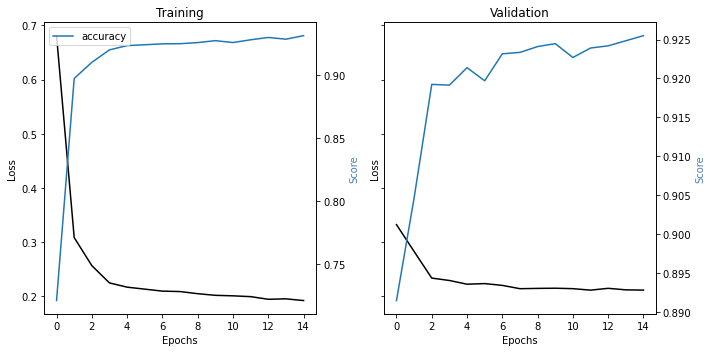

In [53]:
## plot loss and accuracy
plot_training_metrics(training)

In [56]:
def evaluate_model_performance(y_test, predicted, predicted_prob, figsize=(15,5)):
    '''
    Evaluates a model performance.
    :parameter
        :param y_test: array
        :param predicted: array
        :param predicted_prob: array
        :param figsize: tuple - plot setting
    '''
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    accuracy = accuracy_score(y_test, predicted)
    auc_ = roc_auc_score(y_test, predicted_prob, multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc_,2))
    print("Detail:")
    print(classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

In [57]:
## test
predicted_prob = model.predict(X_test)
predicted = np.array([dic_y_mapping[np.argmax(pred)] for pred in predicted_prob])

### Evaluate model performance
- improvement on the under-represented class

Accuracy: 0.87
Auc: 0.94
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.87      0.75      0.81      4843
     POLITICS       0.87      0.94      0.91      9770
         TECH       0.71      0.53      0.61       651

     accuracy                           0.87     15264
    macro avg       0.82      0.74      0.77     15264
 weighted avg       0.86      0.87      0.86     15264



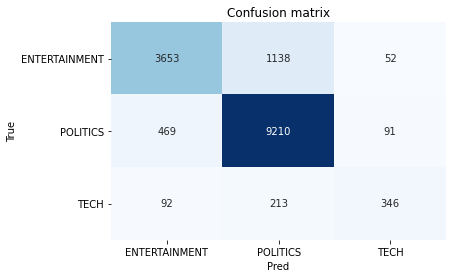

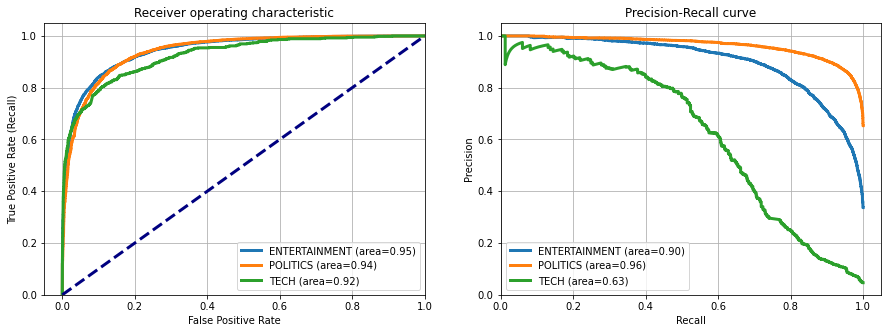

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
evaluate_model_performance(y_test, predicted, predicted_prob)

## Explanatory

test sentence:  Donald Trump Calls Green Party's Wisconsin Recount Push A 'Scam'

True: POLITICS --> Pred: POLITICS | Prob: 0.99


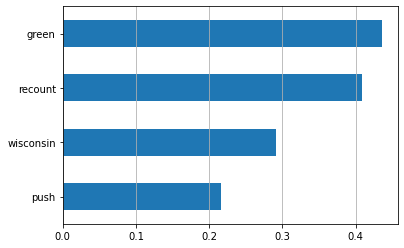

Text with highlighted words


In [59]:
## select observation
i = sample(range(0, len(dtf_test)),1)[0]
txt_instance = dtf_test["text"].iloc[i]
print('test sentence: ',txt_instance)
print()

## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
top =4

### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(lst_corpus), maxlen=15, padding="post", truncating="post")

### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()    # obtain a (_,15,1) vector squeezed and flattened to array of length 15

### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx!= 0]
dic_word_weigth = {word:weights[n] for n, word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}

### 4. barplot
%matplotlib inline
import matplotlib.pyplot as plt

if len(dic_word_weigth) > 0:
    dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
    dtf.sort_values(by="score", 
           ascending=True).tail(top).plot(kind="barh", 
           legend=False).grid(axis='x')
    plt.show()
else:
    print("--- No word recognized ---")
    
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)

### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

# LANGUAGE MODELS using BERT
- Language Models, or Contextualized/Dynamic Word Embeddings, overcome the biggest limitation of the classic Word Embedding approach: polysemy disambiguation, a word with different meanings (e.g. “ bank” or “stick”) is identified by just one vector. One of the first popular ones was ELMO (2018), which doesn’t apply a fixed embedding but, using a bidirectional LSTM, looks at the entire sentence and then assigns an embedding to each word.
- Enter Transformers: a new modeling technique presented by Google’s paper Attention is All You Need (2017) in which it was demonstrated that sequence models (like LSTM) can be totally replaced by Attention mechanisms, even obtaining better performances.
- Google’s BERT (Bidirectional Encoder Representations from Transformers, 2018) combines ELMO context embedding and several Transformers, plus it is bidirectional (which was a big novelty for Transformers). The vector BERT assigns to a word is a function of the entire sentence, therefore, a word can have different vectors based on the contexts.

- illustration: BERT associates DIFFERENT embeddings to SAME word depending on the context

In [85]:
txt = "bank river"
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
## return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]  
embedding = nlp(input_ids)
embedding[0][0]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.34245965,  0.0520038 , -0.25653845, ..., -0.2444183 ,
         0.05279784,  0.44900697],
       [-0.3836248 , -0.6671518 , -0.35021263, ..., -0.10210571,
        -0.21629408, -0.29299933],
       [-0.34996098, -0.08317055, -0.98768264, ...,  0.06963301,
        -0.4945306 , -0.1608822 ],
       [ 0.7392329 ,  0.0739208 , -0.45680907, ..., -0.02415868,
        -0.7649656 , -0.28110704]], dtype=float32)>

In [86]:
txt = "bank money"
## return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]  
embedding = nlp(input_ids)
embedding[0][0]

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.18988547,  0.0568204 , -0.22190535, ..., -0.34671903,
         0.12485142,  0.21270296],
       [ 0.5380039 , -0.15930524, -0.1804364 , ..., -0.45630798,
         0.41015935, -0.3412857 ],
       [-0.28016242, -0.52529323, -0.56609964, ...,  0.18832187,
         0.14473093, -0.15176144],
       [ 0.8138777 ,  0.05597264, -0.23527963, ...,  0.05187678,
        -0.7191797 , -0.19760329]], dtype=float32)>

### to complete a text classification task, you can use BERT in 3 different ways:
- train it all from scratch and use it as classifier. Rare as this is highly computational intensive (days)
- Extract the word embeddings and use them in an embedding layer (like I did with Word2Vec).
- Fine-tuning the pre-trained model (transfer learning). This is what we do in this notebook

In [87]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

### Feature engineering of train set
- We will convert the news into several tokenized sequences used by BERT

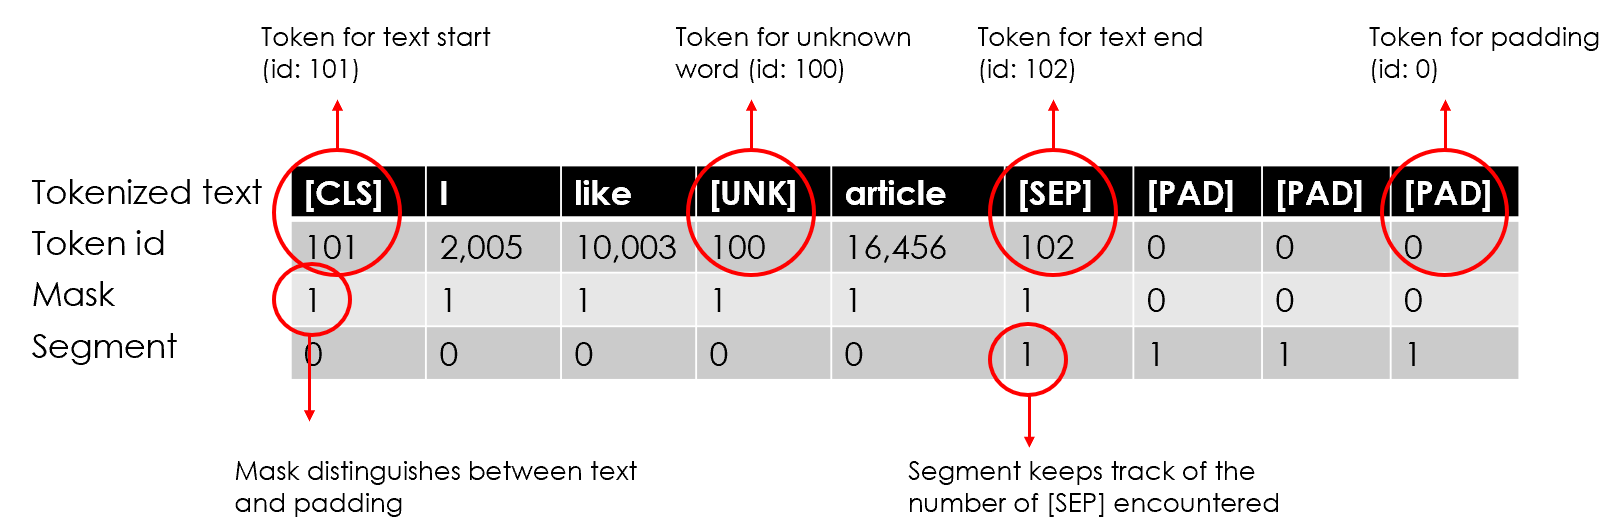

- select higher max_length since BERT splits unknown words into sub-tokens until it finds a known unigram.

In [88]:
def prepare_dataset_for_BERT(df, tokenizer, maxlen = None, dim_input=3):
    
    corpus = df["text"]
    
    maxlen = np.max([len(txt.split(" ")) for txt in corpus]) if maxlen is None else maxlen
    if maxlen < 20:
        raise Exception("maxlen cannot be less than 20")
    else:
        print("maxlen:", maxlen)

    ## add special tokens
    maxqnans = np.int((maxlen-2))
    corpus_tokenized = ["[CLS] "+
                         " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
                         str(txt).lower().strip()))[:maxqnans])+
                         " [SEP]" for txt in corpus]

    ## generate masks
    masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
               txt.split(" "))) for txt in corpus_tokenized]

    ## padding
    txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) <= maxlen else txt for txt in corpus_tokenized]

    ## generate idx
    idx = [tokenizer.encode(seq.split(" "), add_special_tokens=False, trunctation=True, max_length=maxlen) for seq in txt2seq]

    
        
    ## feature matrix
    
    if dim_input==3:
        # This is the expected input format by BERT
        
        ## generate segments
        segments = [] 
        for seq in txt2seq:
            temp, i = [], 0
            for token in seq.split(" "):
                temp.append(i)
                if token == "[SEP]":
                     i += 1
            segments.append(temp)
        
        X = [np.asarray(idx, dtype='int32'), 
            np.asarray(masks, dtype='int32'), 
            np.asarray(segments, dtype='int32')]
        
    else:
        
        # This is the expected input format by DistilBERT
        X = [np.asarray(idx, dtype='int32'), 
            np.asarray(masks, dtype='int32')]
    
    print("created tensor idx-masks-segments:", str(len(X))+"x "+str(X[0].shape))
    
    return X, maxlen

In [89]:
X_train, maxlen = prepare_dataset_for_BERT(dtf_train, tokenizer, dim_input=3)

maxlen: 44


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


created tensor idx-masks-segments: 3x (35615, 44)


In [90]:
i = 0
print("txt: ", dtf_train["text"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

txt:  GOP Congressman Urges Self-Rationing Of Health Care After Obamacare Repeal
tokenized: ['[CLS]', 'go', '##p', 'congressman', 'urges', 'self', '##ration', '##ing', 'of', 'health', 'care', 'after', 'obama', '##care', 'repeal', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
idx:  [  101  2175  2361 12295 23876  2969  8156  2075  1997  2740  2729  2044
  8112 16302 21825   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
mask:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
segment:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]


In [91]:
print(len(X_train[0][i]),len(X_train[1][i]),len(X_train[2][i]))

44 44 44


### Feature engineering of test set

In [92]:
X_test, _ = prepare_dataset_for_BERT(dtf_test, tokenizer, maxlen = maxlen, dim_input=3)

maxlen: 44
created tensor idx-masks-segments: 3x (15264, 44)


### Load pre-trained BERT model and add classification module to fine-tune

In [107]:
## inputs
idx = layers.Input([maxlen], dtype="int32", name="input_idx")
masks = layers.Input([maxlen], dtype="int32", name="input_masks")
segments = layers.Input([maxlen], dtype="int32", name="input_segments")

## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased")
bert_out, _ = nlp([idx, masks, segments])

## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)

## compile
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 44)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 44)]         0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 44)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_4 (TFBertModel)   ((None, 44, 768), (N 109482240   input_idx[0][0]                  
                                                                 input_masks[0][0]          

In [99]:
np.array(X_train).shape

(3, 35615, 44)

### Train BERT

In [117]:
def fit_bert_classifier(X_train, y_train, X_test, dic_y_mapping=None, model=None, epochs=1, batch_size=64):
    '''
    Pre-trained Bert + Fine-tuning (transfer learning) with tf2 and transformers.
    :parameter
        :param X_train: array of sequence
        :param y_train: array of classes
        :param X_test: array of sequence
        :param model: model object - model to fit (before fitting)
        :param encode_y: bool - whether to encode y with a dic_y_mapping
        :param dic_y_mapping: dict - {0:"A", 1:"B", 2:"C"}. If None it calculates
        :param epochs: num - epochs to run
        :param batch_size: num - it does backpropagation every batch, the more the faster but it can use all the memory
    :return
        model fitted and predictions
    '''
    
    ## encode y
    if not dic_y_mapping:
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        
    if type(y_train[0])==str:
        encode_y = False
    else:
        inverse_dic = {v:k for k,v in dic_y_mapping.items()}
        y_train = np.array( [inverse_dic[y] for y in y_train] )
        encode_y = True      
    print('mapping of categories: ', dic_y_mapping)
    
    ## model
    if model is None:
        ### inputs
        idx = layers.Input((X_train[0].shape[1]), dtype="int32", name="input_idx")
        masks = layers.Input((X_train[1].shape[1]), dtype="int32", name="input_masks")
        segments = layers.Input((X_train[2].shape[1]), dtype="int32", name="input_segments")
        ### pre-trained bert
        bert = transformers.TFBertModel.from_pretrained("bert-base-uncased")
        bert_out, _ = bert([idx, masks, segments])
        ### fine-tuning
        x = layers.GlobalAveragePooling1D()(bert_out)
        x = layers.Dense(64, activation="relu")(x)
        y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
        ### compile
        model = models.Model([idx, masks, segments], y_out)
        for layer in model.layers[:4]:
            layer.trainable = False
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
        
    ## train
    verbose = 1 if epochs > 1 else 1
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3)
    
    ## test
    predicted_prob = model.predict(X_test)
    if encode_y is True:
        predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
    else:
        predicted = [np.argmax(pred) for pred in predicted_prob]

    return training, training.model, predicted_prob, predicted

In [113]:
training, model, predicted_prob, predicted = fit_bert_classifier(X_train, y_train, X_test, model=model, epochs=2, batch_size=64)

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}
Epoch 1/2
390/390 [==============================] - 1335s 3s/step - loss: 0.3742 - accuracy: 0.8544 - val_loss: 0.2218 - val_accuracy: 0.9199
Epoch 2/2
390/390 [==============================] - 1359s 3s/step - loss: 0.2423 - accuracy: 0.9090 - val_loss: 0.2305 - val_accuracy: 0.9124


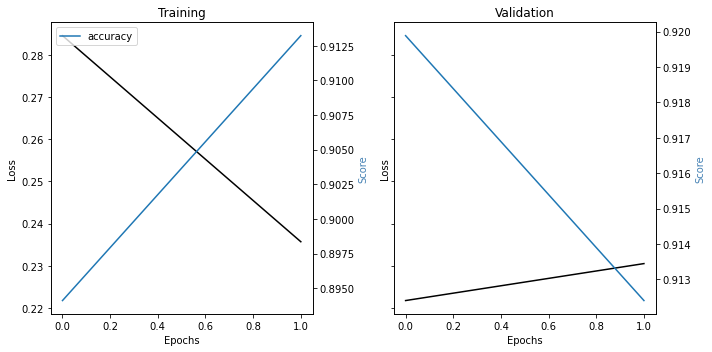

In [114]:
plot_training_metrics(training)

### Evaluate BERT
- significant improvement on the under represented category
- one epoch only would achieve similar results

Accuracy: 0.91
Auc: 0.97
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.85      0.93      0.89      4843
     POLITICS       0.96      0.92      0.94      9770
         TECH       0.79      0.70      0.74       651

     accuracy                           0.91     15264
    macro avg       0.86      0.85      0.85     15264
 weighted avg       0.91      0.91      0.91     15264



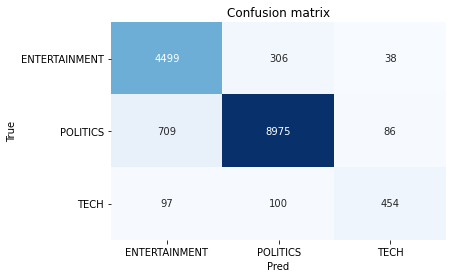

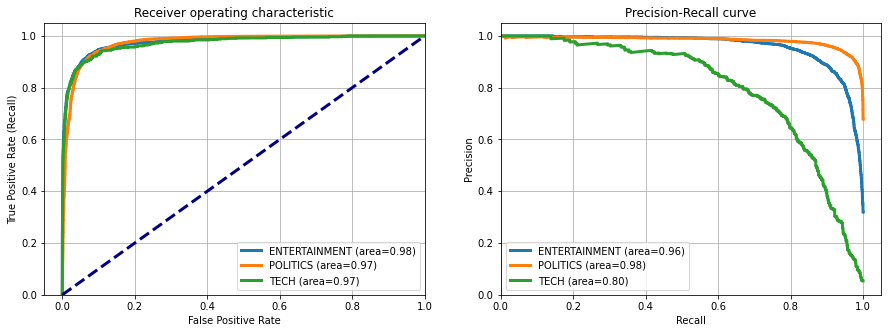

In [115]:
evaluate_model_performance(y_test, predicted, predicted_prob, figsize=(15,5))

## Let's do transfer learning from a pre-trained lighter version of BERT, called Distil-BERT (66 million of parameters instead of 110 million!).

### Using DistilBERT
- MUST redo the feature engineering with the right tokenizer
- The input to the model is only [idx , mask]. The segment information is ignored

### Prepare train and validation set

In [118]:
X_train_distilbert, maxlen_distilbert = prepare_dataset_for_BERT(dtf_train, tokenizer, dim_input=2)
X_test_distilbert, _ = prepare_dataset_for_BERT(dtf_test, tokenizer, maxlen_distilbert, dim_input=2)

maxlen: 44
created tensor idx-masks-segments: 2x (35615, 44)
maxlen: 44
created tensor idx-masks-segments: 2x (15264, 44)


### Instantiate DistilBERT model

In [119]:
## inputs
idx = layers.Input([maxlen_distilbert], dtype="int32", name="input_idx")
masks = layers.Input([maxlen_distilbert], dtype="int32", name="input_masks")

## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
distilbert_nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = distilbert_nlp(idx, attention_mask=masks)[0]

## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)

## compile
DistilBERT_model = models.Model([idx, masks], y_out)
for layer in DistilBERT_model.layers[:3]:
    layer.trainable = False
DistilBERT_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

DistilBERT_model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 44)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 44)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 44, 768),)   66362880    input_idx[0][0]                  
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_3 (Glo (None, 768)          0           tf_distil_bert_model[0][0] 

### Train & visualize losses

In [120]:
## train
DistilBERT_training, DistilBERT_model, Distilbert_predicted_prob, Distilbert_predicted = fit_bert_classifier(X_train_distilbert, y_train, X_test_distilbert, model=DistilBERT_model, epochs=3, batch_size=64)

mapping of categories:  {0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}
Epoch 1/3
390/390 [==============================] - 719s 2s/step - loss: 0.3621 - accuracy: 0.8666 - val_loss: 0.2283 - val_accuracy: 0.9151
Epoch 2/3
390/390 [==============================] - 706s 2s/step - loss: 0.2560 - accuracy: 0.9049 - val_loss: 0.2159 - val_accuracy: 0.9206
Epoch 3/3
390/390 [==============================] - 762s 2s/step - loss: 0.2402 - accuracy: 0.9097 - val_loss: 0.2144 - val_accuracy: 0.9214


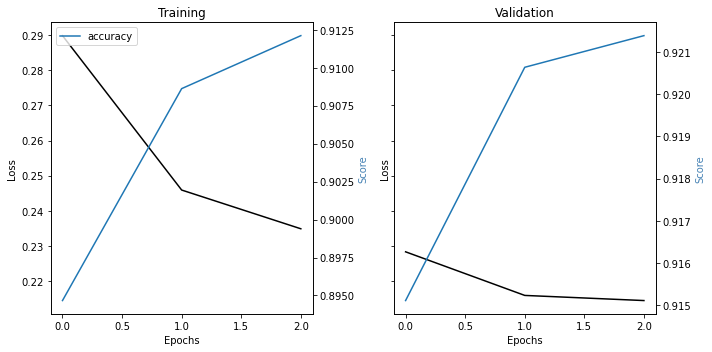

In [121]:
plot_training_metrics(DistilBERT_training)

### Evaluate DistilBERT performance
- very similar performance compared to BERT

Accuracy: 0.92
Auc: 0.98
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.92      0.87      0.89      4843
     POLITICS       0.93      0.96      0.94      9770
         TECH       0.75      0.73      0.74       651

     accuracy                           0.92     15264
    macro avg       0.87      0.85      0.86     15264
 weighted avg       0.92      0.92      0.92     15264



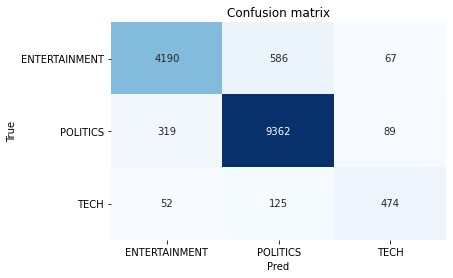

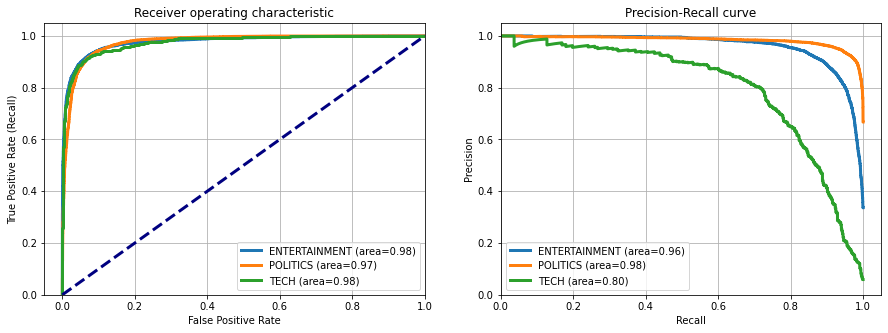

In [122]:
evaluate_model_performance(y_test, Distilbert_predicted, Distilbert_predicted_prob, figsize=(15,5))